In [12]:
import numpy as np
import os
import re
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from tqdm import tqdm
tqdm.pandas()
import time
from hlsstack.hls_funcs.smooth import despike_ts, double_savgol
import gc
from glob import glob
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# input directory
inPATH_wc = '../data/extractions/tmp/snaplands_rr*'

# input file for biomass ground data
inPATH_dat = '../data/ground/2023-2021_RobertsRanch-ResidualEstimates_USDA-ARS.csv'

# unique ID column name
id_col = 'SiteID'

# date column name
date_col = 'Date'

# dependent variable column
y_col = 'biomass_lb_ac'

# output directory
outDIR = '../data/extractions'

# output file
outPATH = os.path.join(outDIR, re.sub('.csv', '_hls_20231115.csv', os.path.basename(inPATH_dat)))

# vegetation indices
veg_list = ['NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7', 
            'SAVI', 'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI', 'TCGI', 'TCWI',
            'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246', 'BAI_346']

# individual bands
band_list = ['BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2']

# whether to apply Bolton mask
mask_bolton_by_id = False

In [14]:
def adapt_smooth(ts, dates, despike=True, dat_thresh=None):
    ct_valid = sum(~np.isnan(ts))
    ct_total = len(ts)
    avg_gap = ct_total/ct_valid
    if ct_valid > 0:
        if avg_gap > 15:
            despike = False
        if despike:
            if dat_thresh is None:
                _dat_thresh = np.ptp(ts.values) * 0.10
            else:
                _dat_thresh = dat_thresh
            ts_ds = despike_ts(ts.values, dat_thresh=_dat_thresh, days_thresh=45)
        else:
            ts_ds = ts.values
        if avg_gap > 10:
            ts_smooth = double_savgol(ts_ds, double=True, window1_max=7, window2=31, limit=91)
        elif avg_gap > 7:
             ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=41, limit=91)
        elif avg_gap > 5:
             ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=51, limit=91)
        else:
            ts_smooth = double_savgol(ts_ds, double=False, window2=51, limit=91)
    else:
        ts_smooth = ts
    return pd.Series(ts_smooth, ts.index.get_level_values(-1))

In [15]:
fLIST = glob(inPATH_wc)
df = pd.read_csv(inPATH_dat, parse_dates=[date_col])

In [16]:
# custom preprocessing for Roberts Ranch dataset
if 'RobertsRanch' in inPATH_dat:
    # create unique ID based on date to address multiple polygons per plot in data
    df['ID'] = df.apply(lambda x: x[id_col] + '_' + str(x[date_col].date()), axis=1)
    # reset the ID columns to be new unique ID
    id_col = 'ID'

In [17]:
df.head(5)

,SiteID,Pasture,Date,Year,Season,biomass_lb_ac,biomass_kg_ha,Lat,Long,_geometry,sitePhotos,ID
0,FE-01,Campbell Springs,2023-10-13,2023,October,1156.0,1295.7604,40.812348,-105.207515,SRID=4326;POINT(-105.20751503041302 40.8123479...,"2023_RobertsRanch_USDA-ARS-27.jpg, 2023_Robert...",FE-01_2023-10-13
1,FE-02,Campbell Springs,2023-10-13,2023,October,1054.0,1181.4286,40.815244,-105.201911,SRID=4326;POINT(-105.20191083218589 40.8152443...,"2023_RobertsRanch_USDA-ARS-25.jpg, 2023_Robert...",FE-02_2023-10-13
2,FE-03,Upper Campbell Vally,2023-10-13,2023,October,1054.0,1181.4286,40.821796,-105.199079,SRID=4326;POINT(-105.19907926349288 40.8217955...,"2023_RobertsRanch_USDA-ARS-21.jpg, 2023_Robert...",FE-03_2023-10-13
3,FE-04,Upper Campbell Vally,2023-10-13,2023,October,986.0,1105.2074,40.820386,-105.196949,SRID=4326;POINT(-105.1969488811203 40.82038633...,"2023_RobertsRanch_USDA-ARS-23.jpg, 2023_Robert...",FE-04_2023-10-13
4,FE-05,Horsehoe North,2023-10-13,2023,October,1088.0,1219.5392,40.828931,-105.180927,SRID=4326;POINT(-105.18092750364805 40.8289305...,"2023_RobertsRanch_USDA-ARS-31.jpg, 2023_Robert...",FE-05_2023-10-13


In [18]:
df_out = None

In [19]:
for yr in df[date_col].dt.year.unique():
    print(yr)

    # get list of files that match year based on path
    fLIST_yr = [x for x in fLIST if str(yr) in os.path.basename(x).split('_')]

    # combine all individual tile files into one dataframe
    df_yr = pd.concat([pd.read_csv(x, parse_dates=[1]) for x in fLIST_yr])
    
    # rename columns to match ground data
    df_yr = df_yr.rename(columns={'time': date_col,
                                  'Plot': id_col})
    
    # convert date to datetime
    df_yr[date_col] = pd.to_datetime(df_yr[date_col])
    
    # remove all non-plot data
    #df_yr = df_yr[df_yr[id_col] != 'UNK']
    
    # remove any dates where bands are negative
    df_yr = df_yr[~((df_yr[band_list] < 0).any(axis=1))]

    # drop any duplicates by taking mean for each plot and date (might exist e.g., from plot on edge of tile during extraction)
    df_yr = df_yr.groupby([id_col, date_col]).mean().reset_index()
    
    # get missing dates for gap-filling
    dates_missing = [x for x in pd.date_range(df_yr[date_col].min(), df_yr[date_col].max()).date if x not in df_yr[date_col].dt.date.unique()]
    
    # convert missing dates to a dataframe for combining with veg index data
    df_missing = pd.DataFrame({
        id_col: list(chain.from_iterable([list(np.repeat(x, len(dates_missing))) for x in df_yr[id_col].unique()])),
        date_col: list(chain.from_iterable(dates_missing for x in df_yr[id_col].unique()))})
    
    df_missing[date_col] = pd.to_datetime(df_missing[date_col])
    
    # combine into one dataframe for gapfilling
    df_yr_ts = pd.concat([df_yr, df_missing]).sort_values([id_col, date_col])
    
    # apply Bolton mask to extracted values
    if mask_bolton_by_id:
        ps_bolton = df_yr_ts.groupby(id_col).progress_apply(lambda x: bolton_mask_np(x['BLUE'], x['SWIR2']))
        df_yr_ts.loc[df_yr_ts[ps_bolton.droplevel(0) == 1.0].index, list(veg_dict.keys()) + band_list] = np.nan
    
    # smooth all vegetation indices to gapfill
    print('Smoothing vegetation indices')
    for vegidx in tqdm(veg_list):
        #df_yr_ts[vegidx + '_smooth'] = df_yr_ts.groupby(id_col)[vegidx].transform(lambda x: double_savgol(x.values))
        vals_smooth_yr = df_yr_ts.groupby(id_col).apply(lambda x: adapt_smooth(x[vegidx], pd.to_datetime(x[date_col])))
        df_yr_ts[vegidx + '_smooth'] = vals_smooth_yr.droplevel(list(np.arange(vals_smooth_yr.index.nlevels-1)))
    print('Smoothing individual bands')
    for band in tqdm(band_list):
        #df_yr_ts[band + '_smooth'] = df_yr_ts.groupby(id_col)[band].transform(lambda x: double_savgol(x.values))
        vals_smooth_yr = df_yr_ts.groupby(id_col).apply(lambda x: adapt_smooth(x[band], pd.to_datetime(x[date_col])))
        df_yr_ts[band + '_smooth'] = vals_smooth_yr.droplevel(list(np.arange(vals_smooth_yr.index.nlevels-1)))
    
    # rename smoothed columns and drop originals
    df_yr_ts = df_yr_ts.drop(columns=veg_list + band_list)
    col_rename_dict = {c: re.sub('_smooth', '', c) for c in df_yr_ts.columns if '_smooth' in c}
    df_yr_ts = df_yr_ts.rename(columns=col_rename_dict)

    # merge with the ground data
    df_out_yr = pd.merge(df[df[date_col].dt.year == yr], 
                         df_yr_ts[[id_col, date_col] + veg_list + band_list], 
                         on=[id_col, date_col],
                         how='left')

    # create or append to final output
    if df_out is not None:
        # merge with existing ouptput dataset
        df_out = pd.concat([df_out, df_out_yr])
    else:
        # create output dataset
        df_out = df_out_yr.copy()

2023
Smoothing vegetation indices


100%|██████████| 22/22 [00:04<00:00,  4.59it/s]


Smoothing individual bands


100%|██████████| 6/6 [00:01<00:00,  4.56it/s]


2022
Smoothing vegetation indices


100%|██████████| 22/22 [00:02<00:00,  7.75it/s]


Smoothing individual bands


100%|██████████| 6/6 [00:00<00:00,  7.79it/s]


2021
Smoothing vegetation indices


100%|██████████| 22/22 [00:02<00:00,  8.01it/s]


Smoothing individual bands


100%|██████████| 6/6 [00:00<00:00,  7.85it/s]


In [20]:
df_out.head(5)

,SiteID,Pasture,Date,Year,Season,biomass_lb_ac,biomass_kg_ha,Lat,Long,_geometry,...,BAI_146,BAI_236,BAI_246,BAI_346,BLUE,GREEN,RED,NIR1,SWIR1,SWIR2
0,FE-01,Campbell Springs,2023-10-13,2023,October,1156.0,1295.7604,40.812348,-105.207515,SRID=4326;POINT(-105.20751503041302 40.8123479...,...,134.820496,144.683016,134.106973,133.129152,623.249779,921.271677,1293.548976,2206.857647,3115.907835,2263.314248
1,FE-02,Campbell Springs,2023-10-13,2023,October,1054.0,1181.4286,40.815244,-105.201911,SRID=4326;POINT(-105.20191083218589 40.8152443...,...,133.162182,144.688298,132.303604,130.678393,613.936046,899.843649,1246.647314,2166.110909,3010.473601,2014.814815
2,FE-03,Upper Campbell Vally,2023-10-13,2023,October,1054.0,1181.4286,40.821796,-105.199079,SRID=4326;POINT(-105.19907926349288 40.8217955...,...,130.401742,140.166501,129.927720,129.322901,760.875937,1092.710679,1503.188702,2465.304786,3250.822844,2306.374057
3,FE-04,Upper Campbell Vally,2023-10-13,2023,October,986.0,1105.2074,40.820386,-105.196949,SRID=4326;POINT(-105.1969488811203 40.82038633...,...,133.149975,142.912301,132.834626,132.208042,773.103638,1109.953283,1512.533959,2464.517900,3485.905394,2540.632381
4,FE-05,Horsehoe North,2023-10-13,2023,October,1088.0,1219.5392,40.828931,-105.180927,SRID=4326;POINT(-105.18092750364805 40.8289305...,...,128.914306,140.923728,128.643906,127.442782,621.639054,959.267360,1339.883404,2305.939636,2966.570841,1974.473307


In [21]:
# look for any missing data
df_out[df_out['NDVI'].isnull()].sort_values('SiteID')

,SiteID,Pasture,Date,Year,Season,biomass_lb_ac,biomass_kg_ha,Lat,Long,_geometry,...,BAI_146,BAI_236,BAI_246,BAI_346,BLUE,GREEN,RED,NIR1,SWIR1,SWIR2


In [27]:
# look for any duplicated ID's
df_out[df_out.duplicated(subset=[id_col, date_col], keep=False)].sort_values(id_col)

,SiteID,Pasture,Date,Year,Season,biomass_lb_ac,biomass_kg_ha,Lat,Long,_geometry,...,BAI_146,BAI_236,BAI_246,BAI_346,BLUE,GREEN,RED,NIR1,SWIR1,SWIR2


In [25]:
# get mean or drop duplicated ID's
df_out = df_out.drop_duplicates(subset=[id_col, date_col], keep='first')

<AxesSubplot:>

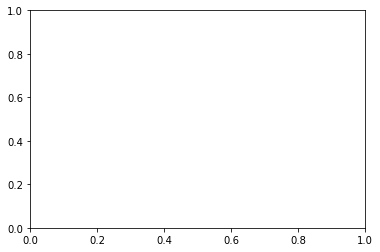

In [26]:
plot = 'T-107'
x_col = 'SWIR2'
p = sns.lineplot(x='Date', y=x_col, data=df_yr_ts[df_yr_ts[id_col] == plot])
sns.scatterplot(x='Date', y=x_col, data=df_yr[df_yr[id_col] == plot], ax=p)

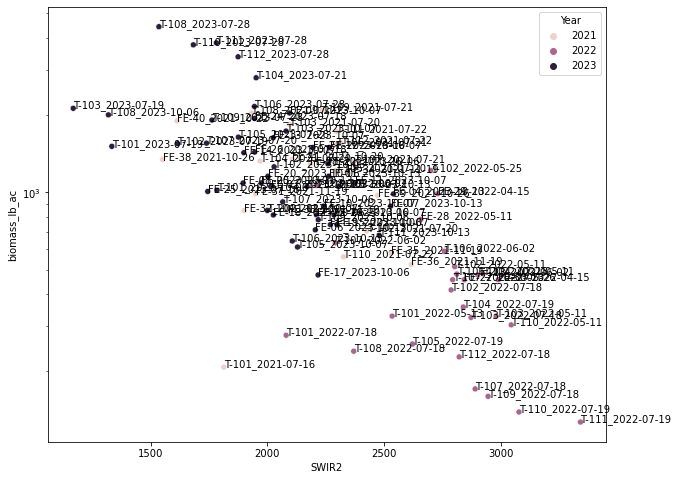

In [29]:
x_col = 'SWIR2'
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x=x_col, y=y_col, data=df_out, hue='Year', ax=ax)
df_out.apply(lambda x: ax.text(x[x_col],  x[y_col], x[id_col]), axis=1)
plt.yscale('log')

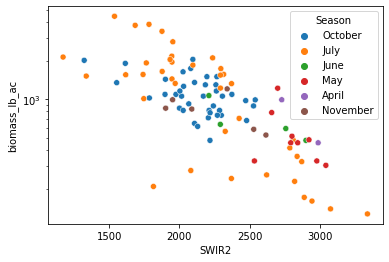

In [30]:
sns.scatterplot(x=x_col, y=y_col, data=df_out, hue='Season')
plt.yscale('log')

In [31]:
df_out.to_csv(outPATH, index=False)